# CHF/PLN Forecasting

### Import libraries

In [38]:
from typing import Final

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# seed for reproducibility
np.random.seed(42)

### Load dataset

In [39]:
df: pd.DataFrame = pd.read_csv(r"../data/chfpln_d.csv", parse_dates=True)
df.head(10)

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie
0,1984-01-02,0.0045,0.0045,0.0045,0.0045
1,1984-01-09,0.0044,0.0044,0.0044,0.0044
2,1984-01-16,0.0044,0.0044,0.0044,0.0044
3,1984-01-23,0.0044,0.0044,0.0044,0.0044
4,1984-01-30,0.0044,0.0044,0.0044,0.0044
5,1984-02-06,0.0044,0.0044,0.0044,0.0044
6,1984-02-13,0.0044,0.0044,0.0044,0.0044
7,1984-02-20,0.0044,0.0044,0.0044,0.0044
8,1984-03-01,0.0050,0.0050,0.0050,0.0050
9,1984-03-05,0.0050,0.0050,0.0050,0.0050


### Data overview

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9221 entries, 0 to 9220
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        9221 non-null   object 
 1   Otwarcie    9221 non-null   float64
 2   Najwyzszy   9221 non-null   float64
 3   Najnizszy   9221 non-null   float64
 4   Zamkniecie  9221 non-null   float64
dtypes: float64(4), object(1)
memory usage: 360.3+ KB


In [41]:
df['Data'] = pd.to_datetime(df['Data'])

### Explore the data

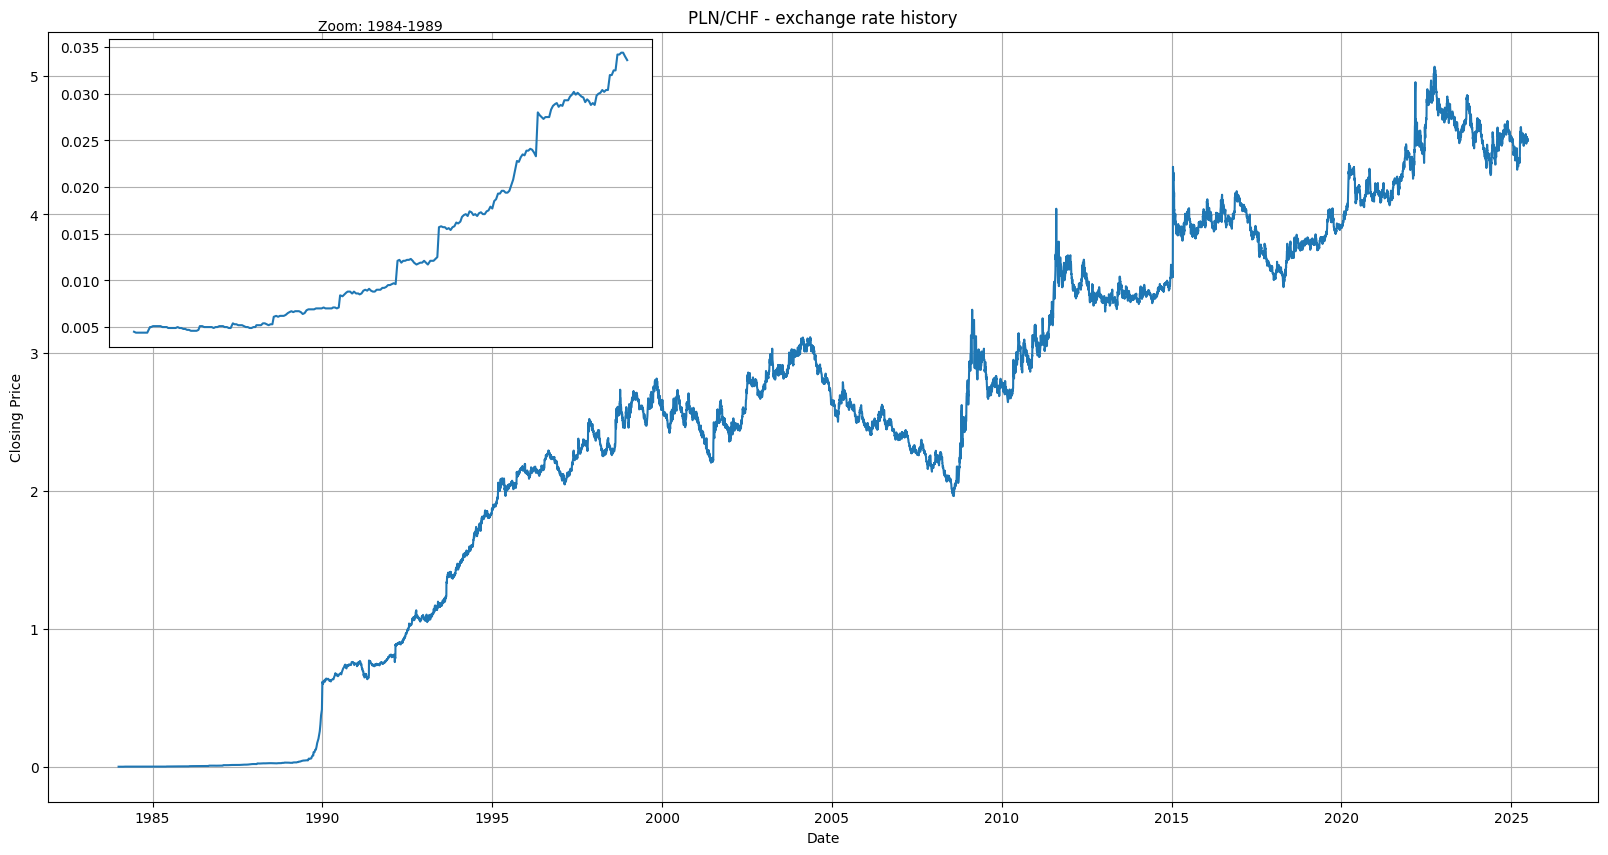

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title('PLN/CHF - exchange rate history')
ax.plot(df['Data'], df['Zamkniecie'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.grid(True)

axins = inset_axes(ax, width="35%", height="40%", loc='upper left', bbox_to_anchor=[0.035, 0, 1, 1], bbox_transform=ax.transAxes)

start_date = pd.to_datetime("1984-01-01")
end_date = pd.to_datetime("1989-01-01")
mask = (df['Data'] >= start_date) & (df['Data'] <= end_date)

axins.plot(df['Data'][mask], df['Zamkniecie'][mask])
axins.set_xticks([])

axins.set_title("Zoom: 1984-1989", fontsize=10)

axins.grid(True)

plt.show()

In [43]:
X = df.drop(columns=['Zamkniecie'])
y = df['Zamkniecie']

In [44]:
def create_sequences(data: np.ndarray, sequence_length: int = 10):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [45]:
SEQUENCE_LENGTH: Final[int] = 30


X, y = create_sequences(data=y, sequence_length=SEQUENCE_LENGTH)

split_idx = int(0.70 * len(X)) # 70% test, 30% train
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [46]:
from keras.src.layers import LSTM, Dropout, Dense
from keras import Sequential

model = Sequential()
# LSTM layer with 50 neurons, return sequences for the next LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQUENCE_LENGTH, 1)))
# Dropout layer to prevent overfitting
model.add(Dropout(0.2))
# Second LSTM layer with 50 neurons, return only the last output
model.add(LSTM(units=50, return_sequences=False))
# Another Dropout layer
model.add(Dropout(0.2))
# Further feature extraction
model.add(Dense(units=25))
# Output layer with 1 neuron
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

C:\Users\kacpe\Desktop\CHF-PLN-forecast\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.8191 - val_loss: 0.1781
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0537 - val_loss: 0.0206
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0393 - val_loss: 0.0413
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0338 - val_loss: 0.0133
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0362 - val_loss: 0.0630
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0276 - val_loss: 0.0273
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0235 - val_loss: 0.0119
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0227 - val_loss: 0.0103
Epoch 9/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0195 - val_loss: 0.0358
Epoch 10/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0180 - val_loss: 0.0722
Epoch 11/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0170 - val_loss: 0.0237
Epoch 12/100
202/202 ━━━━━━━━━

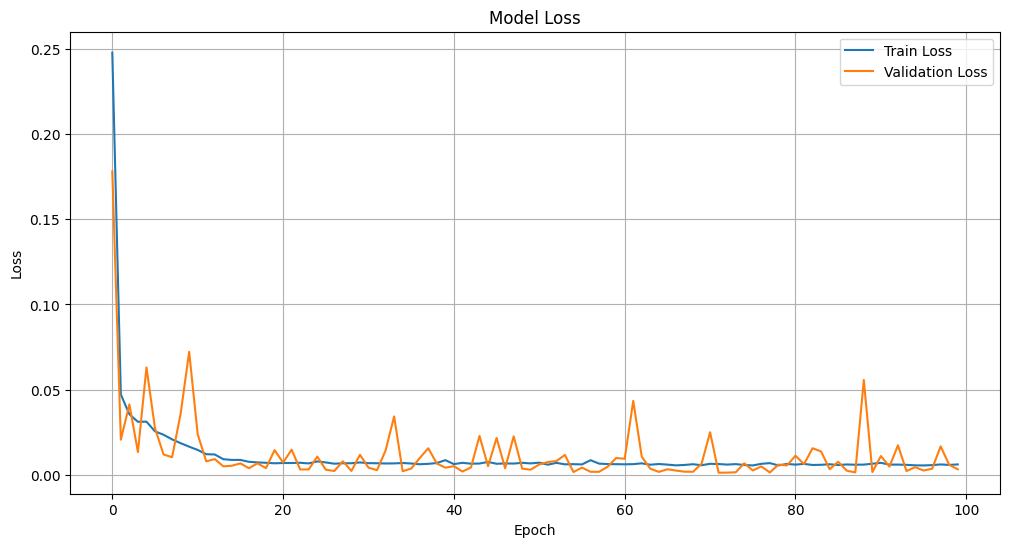

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


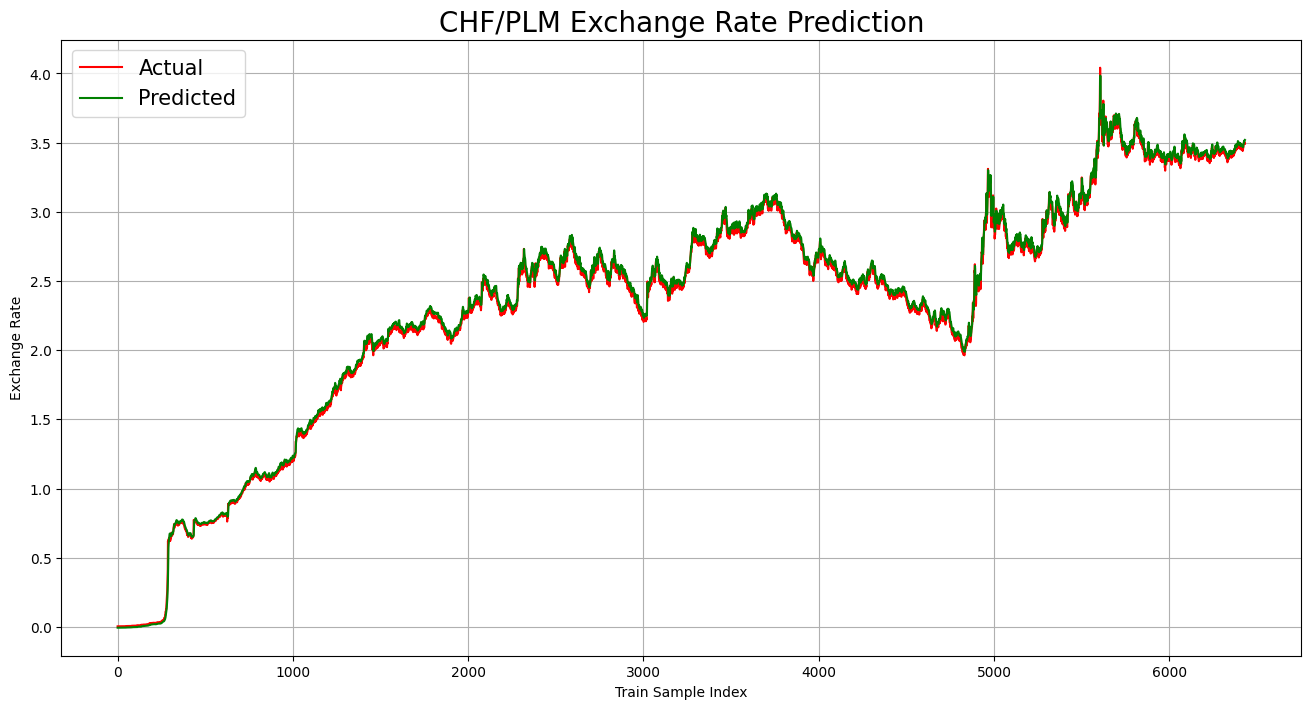

In [49]:
predictions = model.predict(X_train)

plt.figure(figsize=(16, 8))
plt.plot(y_train.reshape(-1, 1), c='red', label='Actual')
plt.plot(predictions, c='green', label='Predicted')
plt.title('CHF/PLM Exchange Rate Prediction', fontsize=20)
plt.xlabel('Train Sample Index')
plt.ylabel('Exchange Rate')
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

In [50]:
def predict_future_chf(day: int, month: int, year: int):
    """ Predict the CHF/PLN exchange rate for a given date."""

    # Last known sequence from the dataset
    last_known_sequence = X[-1:]

    # Last date in the dataset
    current_date = df['Data'].max()

    target_date = pd.to_datetime(f"{year}-{month}-{day}")

    days_to_predict = (target_date - current_date).days

    if days_to_predict <= 0:
        return "Target date must be in the future"

    # Predict future values
    future_predictions = []
    current_sequence = last_known_sequence.copy()

    for _ in range(days_to_predict):
        next_pred = model.predict(current_sequence, verbose=0)
        next_value = next_pred[0][0] # Get the predicted value
        future_predictions.append(next_value)

        # Update the current sequence by rolling it and adding the new prediction
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1] = next_value

    return future_predictions[-1]


In [51]:
predicted_value = predict_future_chf(day=1, month=8, year=2025)
print(f"Predicted CHF/PLN rate: {predicted_value:.4f}")


Predicted CHF/PLN rate: 4.0892


In [52]:
# save model
model.save('../models/chf_pln_forecast.keras')